# DLMI - Lymphocytosis classification
## One-to-one image model: CNN and augmented data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader
from utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_dir = "../../data/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"
augmented_data_dir = "../../data/dlmi-lymphocytosis-augmented-data/"

In [4]:
augmented_images = {"augmented": []}
for image_path in os.listdir(augmented_data_dir):
    augmented_images["augmented"].append(os.path.join(augmented_data_dir, image_path))

In [5]:
train_val_images = load_images(train_dir)
test_images = load_images(test_dir)

In [6]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
labels_dict = dict(zip(trainset_true_df["ID"], trainset_true_df["LABEL"]))

In [7]:
n_id_val_per_class = 25

id_train_val = np.array(list(train_val_images.keys()))
labels = np.array([labels_dict[id] for id in id_train_val])

id_train_val_0 = id_train_val[labels == 0]
id_train_val_1 = id_train_val[labels == 1]

id_val_0 = np.random.choice(id_train_val_0, size=n_id_val_per_class + 4, replace=False)
id_val_1 = np.random.choice(id_train_val_1, size=n_id_val_per_class - 4, replace=False)

id_val = np.concatenate([id_val_0, id_val_1])
mask = np.isin(id_train_val, id_val, invert=True)
id_train = id_train_val[mask]

id_train.shape, id_val.shape

((113,), (50,))

In [8]:
train_images = {id: train_val_images[id] for id in id_train}
val_images = {id: train_val_images[id] for id in id_val}

X_train, y_train = assign_labels(train_images, labels_dict)
X_val, y_val = assign_labels(val_images, labels_dict)
len(X_train), len(X_val)

(10252, 3201)

In [9]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1089, 9163]))

In [10]:
np.unique(y_val, return_counts=True)

(array([0, 1]), array([1503, 1698]))

In [11]:
n_images = len(augmented_images["augmented"])
X_train.extend(augmented_images["augmented"][:n_images])
y_train.extend([0]*n_images)
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8365, 9163]))

In [12]:
transform_function = lambda x: x.reshape(3, x.shape[0], x.shape[1])

In [13]:
batch_size = 32
train_dataset = ImageLabelDataset(X_train, y_train, transform_function)
test_dataset = ImageLabelDataset(X_val, y_val, transform_function)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4,
                    kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=4, out_channels=8,
                    kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16,
                    kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Sequential(
                nn.Linear(12544, 128),
                nn.ReLU(),
                nn.Linear(128, 2)
            )
        )

    def forward(self, x):
        return self.model(x)

[Epoch 1 / 50]
	train loss = 0.66052 acc = 0.86793 bacc = 0.86565
	test loss = 7.50713 acc = 0.53046 bacc = 0.50000
[Epoch 2 / 50]
	train loss = 0.20383 acc = 0.92675 bacc = 0.92479
	test loss = 1.55562 acc = 0.54608 bacc = 0.51694
[Epoch 3 / 50]
	train loss = 0.19186 acc = 0.92937 bacc = 0.92723
	test loss = 1.74523 acc = 0.53077 bacc = 0.50033
[Epoch 4 / 50]
	train loss = 0.18022 acc = 0.93279 bacc = 0.93054
	test loss = 1.32326 acc = 0.56670 bacc = 0.53897
[Epoch 5 / 50]
	train loss = 0.17455 acc = 0.93508 bacc = 0.93288
	test loss = 3.10738 acc = 0.49609 bacc = 0.52430
[Epoch 6 / 50]
	train loss = 0.17620 acc = 0.93473 bacc = 0.93260
	test loss = 2.43334 acc = 0.53046 bacc = 0.50000
[Epoch 7 / 50]
	train loss = 0.18083 acc = 0.93411 bacc = 0.93188
	test loss = 1.94879 acc = 0.53171 bacc = 0.50133
[Epoch 8 / 50]
	train loss = 0.19720 acc = 0.93011 bacc = 0.92791
	test loss = 0.69137 acc = 0.66198 bacc = 0.64895
[Epoch 9 / 50]
	train loss = 0.17705 acc = 0.93439 bacc = 0.93261
	test 

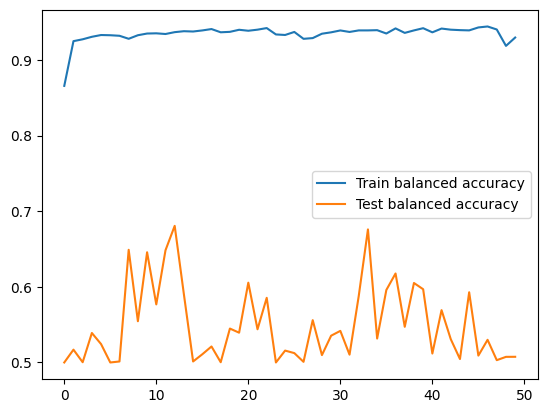

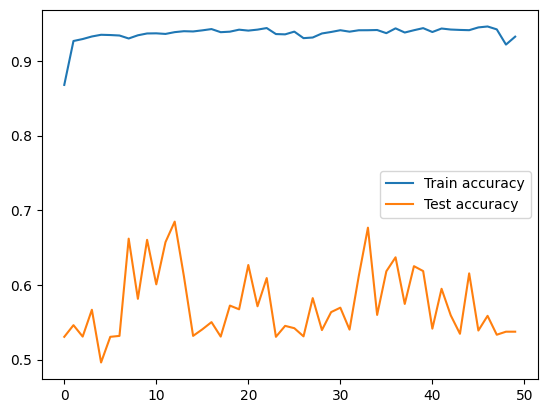

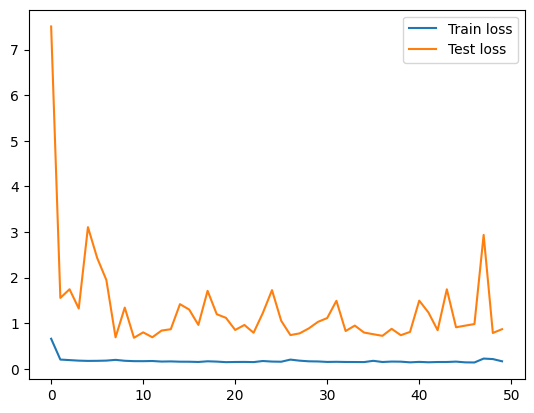

In [15]:
model = CNN().to(device)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 50
trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs,
    device=device, verbose=True, verbose_every=1, plot=True
)

In [16]:
y_true_val = np.array([labels_dict[p] for p in val_images.keys()])
y_pred_min = predict_all(
    model, val_images, transform_function, batch_size=batch_size, 
    prediction_aggregator=PredictionAggregator.MIN, device=device
)
y_pred_max = predict_all(
    model, val_images, transform_function, batch_size=batch_size, 
    prediction_aggregator=PredictionAggregator.MAX, device=device
)
y_pred_mean = predict_all(
    model, val_images, transform_function, batch_size=batch_size, 
    prediction_aggregator=PredictionAggregator.MEAN, device=device
)

In [17]:
acc = metrics.accuracy_score(y_true_val, y_pred_min)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred_min)
print(f"Min acc = {acc:.5f} bal. acc = {balanced_acc:.5f}")
acc = metrics.accuracy_score(y_true_val, y_pred_max)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred_max)
print(f"Max acc = {acc:.5f} bal. acc = {balanced_acc:.5f}")
acc = metrics.accuracy_score(y_true_val, y_pred_mean)
balanced_acc = metrics.balanced_accuracy_score(y_true_val, y_pred_mean)
print(f"Mean acc = {acc:.5f} bal. acc = {balanced_acc:.5f}")

Min acc = 0.58000 bal. acc = 0.60509
Max acc = 0.42000 bal. acc = 0.50000
Mean acc = 0.42000 bal. acc = 0.50000
